In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=1j7AVfp75_ZWoqxQa3tWoBL6z-ApobsCl'
fluff, id = link.split('=')
file = drive.CreateFile({'id':id}) # replace the id with id of file you want to access
file.GetContentFile('ratings.csv') 

# Question 1: Compute the sparsity of the movie rating dataset.

In [0]:
import pandas as pd
import numpy as np

df = pd.read_csv('ratings.csv')


R_matrix = df.pivot_table(index=['userId'], values=['rating'], columns=['movieId'], fill_value=0).values
total_available = len(df)
total_possible = np.prod(R_matrix.shape)
Sparsity = total_available / total_possible

print('sparsity is: ', Sparsity)

"\nR_matrix = df.pivot_table(index=['userId'], values=['rating'], columns=['movieId'], fill_value=0).values\ntotal_available = len(df)\ntotal_possible = np.prod(R_matrix.shape)\nSparsity = total_available / total_possible\n\nprint('sparsity is: ', Sparsity)"

In [0]:
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


# Question 2


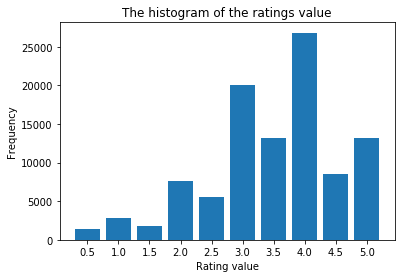

In [0]:
import numpy as np
import matplotlib.pyplot as plt

Rating = df['rating'].values
hist, _ = np.histogram(Rating, np.arange(0, 11) * 0.5 + 0.1)  # set bias for the 
bar_width = 0.4
bin_edges = np.arange(1, 11) * 0.5
plt.bar(bin_edges, hist, bar_width)
plt.xticks(bin_edges, bin_edges)
plt.xlabel('Rating value')
plt.ylabel('Frequency')
plt.title('The histogram of the ratings value')
plt.savefig('Rating_Hist.eps')
plt.show()

# Question 3


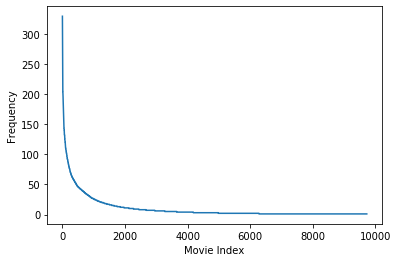

In [0]:
Comment_or_Not = R_matrix > 0
N_user, N_movie = R_matrix.shape
# change the one dimensional array to reversed order.
movies_rating = -np.sum(Comment_or_Not, 0)
movies_rating.sort()
movies_rating = -movies_rating

plt.plot(np.arange(1, N_movie + 1), movies_rating)
plt.xlabel('Movie Index')
plt.ylabel('Frequency')
plt.savefig('Distribution_Rating')
plt.show()

# Question 4


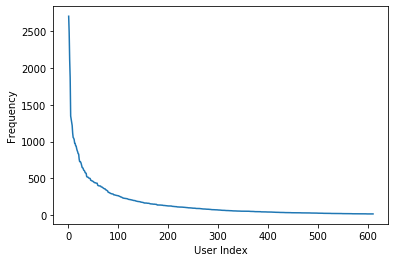

In [0]:
users_rating = -np.sum(Comment_or_Not, 1)
users_rating.sort()
users_rating = -users_rating

plt.plot(np.arange(1, 1 + N_user), users_rating)
plt.xlabel('User Index')
plt.ylabel('Frequency')
plt.savefig('Distribution_User')
plt.show()

# Question 6


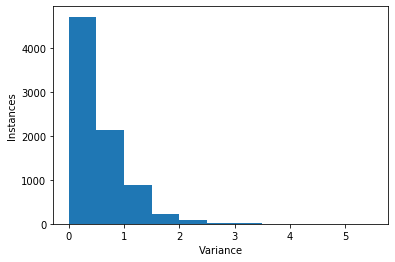

In [0]:
import math
movieID = df['movieId'].values
N_rating = len(Rating)
VMN = np.zeros(shape=(max(movieID), 3))
for i in range(N_rating):
    id_m = movieID[i] - 1
    variance = VMN[id_m, 0]
    mean = VMN[id_m, 1]
    N = VMN[id_m, 2]
    rating = Rating[i]
    new_mean = (mean * N + rating) / (N + 1)
    total_variance = variance * N + N * (mean - new_mean) ** 2 + (
            rating - new_mean) ** 2
    new_variance = total_variance / (N + 1)
    VMN[id_m, 0] = new_variance
    VMN[id_m, 1] = new_mean
    VMN[id_m, 2] = N + 1

variance_tuple = [VMN[i, 0] for i in range(N_rating) if VMN[i, 2]]
bin_num = math.ceil(max(variance_tuple) * 2)
bin_edges = np.arange(bin_num + 1) * 0.5
plt.hist(variance_tuple, bin_edges)
plt.xlabel('Variance')
plt.ylabel('Instances')
plt.savefig('Hist_variance.png')
plt.show()


# Question 10


In [0]:
!pip install scikit-surprise
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms.knns import KNNWithMeans


Truncateddf = df.iloc[:, :3]
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(Truncateddf, reader)

sim_options = {
    'name': 'pearson',
    'user_based': True
}
K_tuple = np.arange(2, 102, 2)
test_rmse = []
test_mae = []
for k in K_tuple:
    algo = KNNWithMeans(k=k, sim_options=sim_options)
    r_dict = cross_validate(algo, data, measures=['rmse', 'mae'], cv=10)
    rmse_array = r_dict['test_rmse']
    mae_array = r_dict['test_mae']
    test_rmse.append(rmse_array.mean())
    test_mae.append(mae_array.mean())

metrics_dict = {
    'RMSE': test_rmse,
    'MAE': test_mae
}


     |████████████████████████████████| 6.5MB 2.8MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.0-cp36-cp36m-linux_x86_64.whl size=1678239 sha256=23e4dba2159d1ae3ea9c6b1c191e78db8703e9b989482711cb17b4e2d4bcde73
  Stored in directory: /root/.cache/pip/wheels/cc/fa/8c/16c93fccce688ae1bde7d979ff102f7bee980d9cfeb8641bcf
Successfully built scikit-surprise
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Comput

0.892353406639495


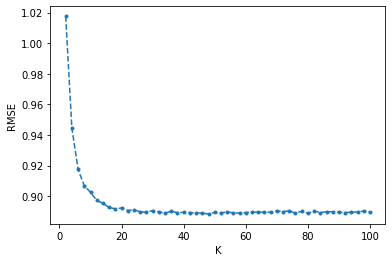

0.679906885024829


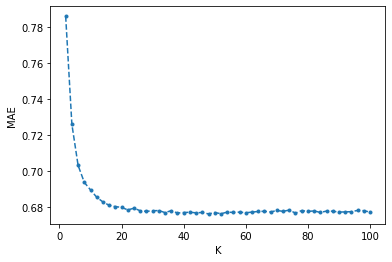

In [0]:
for metrics_name in metrics_dict.keys():
    plt.xlabel('K')
    plt.ylabel(metrics_name)
    plt.plot(K_tuple, metrics_dict[metrics_name],'--.')
    print(metrics_dict[metrics_name][9])
    plt.savefig(metrics_name)
    plt.show()


# Question 12, 13, 14


In [0]:
from collections import defaultdict

def popular_trimming(dataset, VMN):
    N = len(dataset)
    trimmed_dataset = []
    for i in range(N):
        movieID = dataset[i][1]
        if VMN[movieID - 1, 2] > 2:
            trimmed_dataset.append(dataset[i])

    return trimmed_dataset


def unpopular_trimming(dataset, VMN):
    N = len(dataset)
    trimmed_dataset = []
    for i in range(N):
        movieID = dataset[i][1]
        if VMN[movieID - 1, 2] <= 2:
            trimmed_dataset.append(dataset[i])

    return trimmed_dataset


def high_variance_trimming(dataset, VMN):
    N = len(dataset)
    trimmed_dataset = []
    for i in range(N):
        movieID = dataset[i][1]
        if VMN[movieID - 1, 2] >= 5 and VMN[movieID - 1, 0] >= 2:
            trimmed_dataset.append(dataset[i])

    return trimmed_dataset

def precision_recall(pred, t, threshold=3):
    user_truth = defaultdict(list)
    precision = {}
    recall = {}
    for uid, _, true_r, est, _ in pred:
        user_truth[uid].append((est, true_r))
    for uid, user_ratings in user_truth.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        num_recommended = t
        num_rel_rec = 0
        for i in range(t):
            if user_ratings[i][1] >= threshold:
                num_rel_rec += 1
        num_relevent = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        precision[uid] =  num_rel_rec / num_recommended
        recall[uid] = num_rel_rec /  num_relevent
    return precision, recall

def datatrim(data, t, threshold=3):
    count = {}
    like = {}
    for uid, _, rating in data:
        if uid not in count:
            count[uid] = 0
        count[uid] += 1
        if uid not in like:
            like[uid] = 0
        if rating >= threshold:
            like[uid] += 1     
    result = []
    for uid, movieId, rating in data:
        if count[uid] >= t and like[uid] > 0:
            result.append((uid, movieId, rating))
    return result

In [0]:
from surprise import  accuracy
from surprise.model_selection import KFold

trim_dict ={
    'popular_trimmed': popular_trimming,
    'unpopular_trimmed': unpopular_trimming,
    'high_variance_trimmed': high_variance_trimming
}
sim_options =  {
    'name' : 'pearson',
    'user_based': True
}

N_splits = 10
kf = KFold(n_splits=N_splits)

length = len(K_tuple)
trimmed_test_rmse = {}
# construct the dictionary for ploting and analyzing
for trim_name in trim_dict.keys():
    trimmed_test_rmse[trim_name] = [0] * length

for i in range(length):
    algo = KNNWithMeans(k=K_tuple[i], sim_options=sim_options)
    for trainset, testset in kf.split(data):
        algo.fit(trainset)
        for trim_name in trim_dict.keys():
            trim_method = trim_dict[trim_name]
            trimmed_test_set = trim_method(testset, VMN)
            predictions = algo.test(trimmed_test_set)
            trimmed_test_rmse[trim_name][i] += accuracy.rmse(predictions, verbose=False)
    for trim_name in trim_dict.keys():
        trimmed_test_rmse[trim_name][i] /= 10

print ('Complete calculation!')

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

minimum RMSE for popular_trimmed is 0.8716


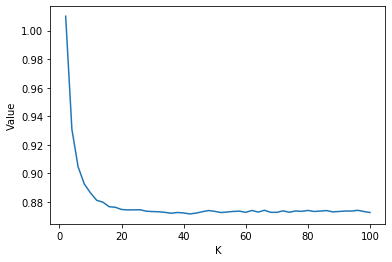

minimum RMSE for unpopular_trimmed is 1.1076


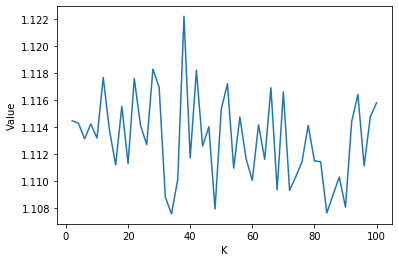

minimum RMSE for high_variance_trimmed is 1.5016


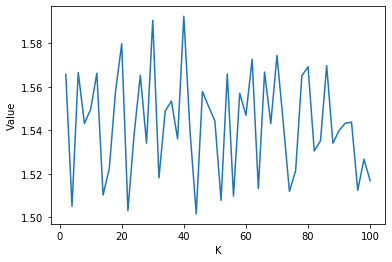

In [0]:
for trim_name in trim_dict.keys():
    plt.xlabel('K')
    plt.ylabel('Value')
    plt.plot(K_tuple, trimmed_test_rmse[trim_name])
    print ('minimum RMSE for %s is %0.4f' %(trim_name, min(trimmed_test_rmse[trim_name])))
    plt.show()

#Question 15

In [0]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def binarization(Prediction_list, threshold):
    return [1 if Prediction[2] > threshold else 0 for Prediction in Prediction_list]


def plot_roc(fpr, tpr, image_name):
    fig, ax = plt.subplots()
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, lw=2, label='area under curve = %0.4f' % roc_auc)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Postive Rate')
    ax.legend(loc='lower right')
    plt.savefig(image_name + '_roc.pdf')


def fit_predict_and_plot_roc(model, train_data, test_data, threshold, method_name):
    '''
    Notice that the model.test(test_data) outputs a list composed by the Prediction class.
    Class Prediction
    parameters:
    1. uid - The raw user id.
    2. iid - The raw item id.
    3. r_ui- The true rating.
    4. est = The estimated rating.
    5. details - Stores addiational details about the prediction that might be useful for later analysis.
    '''
    model.fit(train_data)
    predictions = model.test(test_data)
    estimation_score = [predict[3] for predict in predictions]
    binarized_test = binarization(predictions, threshold)
    fpr, tpr, _ = roc_curve(binarized_test, estimation_score)
    plot_roc(fpr, tpr, method_name+'_'+str(threshold))


Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.


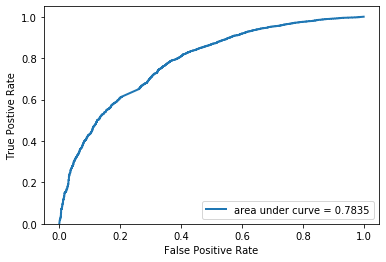

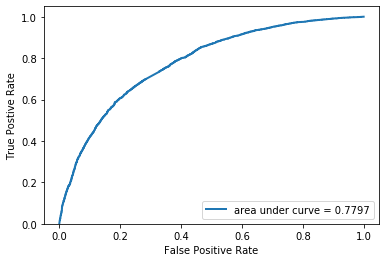

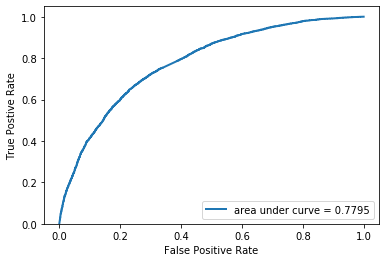

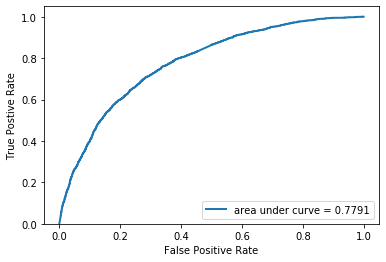

In [0]:
from surprise.model_selection.split import train_test_split

train_set, test_set = train_test_split(data, test_size=0.1)

optimal_k = 20
algo = KNNWithMeans(k=optimal_k, sim_options=sim_options)
Threshold_tuple = [2.5, 3, 3.5, 4]
for threshold in Threshold_tuple:
    fit_predict_and_plot_roc(algo, train_set,test_set, threshold, 'KNN')

#Question 17

In [0]:
!pip install scikit-surprise
from surprise import NMF
from surprise.model_selection import cross_validate
from surprise import Dataset
from surprise import Reader

aver_rmses = []
aver_maes = []
Truncateddf = df.iloc[:, :3]
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(Truncateddf, reader)


K_tuple = np.arange(2, 52, 2)


for k in K_tuple:
    algo = NMF(n_factors=k,biased=False)
    result_dict = cross_validate(algo, data, measures=['rmse', 'mae'], cv=10)
    aver_rmse = np.average(result_dict['test_rmse'])
    aver_rmses.append(aver_rmse)
    aver_mae =  np.average(result_dict['test_mae'])
    aver_maes.append(aver_mae)



plt.plot(K_tuple, aver_rmses, label='Average RMSE')
plt.plot(K_tuple, aver_maes, label='Average MAE')
plt.title("Average RMSE and average MAE against k")
plt.xlabel('k')
plt.ylabel('Average value')
plt.legend()
plt.grid()
plt.show()

print('Average RMSE:\n', aver_rmses,'\nAverage MAE:\n', aver_maes)

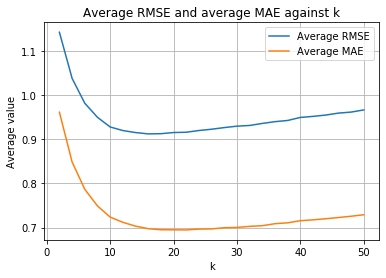

Average RMSE:
 [1.14318455114355, 1.0385575023364308, 0.9821536500780612, 0.9501452782858439, 0.9282539515900297, 0.9201454286017097, 0.915565265687761, 0.9125387668923486, 0.9129897968305192, 0.9156166597170975, 0.9162637166905249, 0.9202033991355327, 0.9231221445415756, 0.9268446328719733, 0.9300662003594384, 0.9316712445147719, 0.9362555242726742, 0.9403003632208945, 0.9429838425155619, 0.9499088054391471, 0.9522701007967674, 0.9552480536022291, 0.9596780337949837, 0.9620267059391724, 0.9669212253268871] 
Average MAE:
 [0.9616764305222958, 0.8488648805976146, 0.7868063358979094, 0.749102626407179, 0.7238331842152105, 0.7119206473345459, 0.7032069540021931, 0.6974852142342705, 0.6950375302061492, 0.6948609737314749, 0.6946512088861595, 0.6965033104015418, 0.6969161211173837, 0.6996866190566228, 0.7002611897671432, 0.7027250459512168, 0.7042531439754413, 0.708752408069926, 0.7107690815509398, 0.7155739953926648, 0.7174817075258548, 0.7200240078670539, 0.7227651432373013, 0.72570435623

In [0]:
import matplotlib.pyplot as plt

plt.plot(K_tuple, aver_rmses, label='Average RMSE')
plt.plot(K_tuple, aver_maes, label='Average MAE')
plt.title("Average RMSE and average MAE against k")
plt.xlabel('k')
plt.ylabel('Average value')
plt.legend()
plt.grid()
plt.show()

print('Average RMSE:\n', aver_rmses,'\nAverage MAE:\n', aver_maes)

#Question 19, 20, 21

minimum RMSE for popular_trimmed is 0.8919


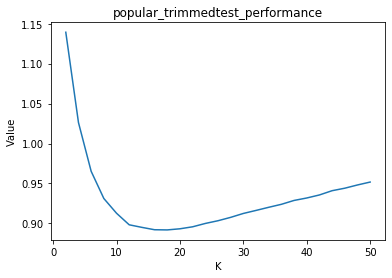

minimum RMSE for unpopular_trimmed is 1.1646


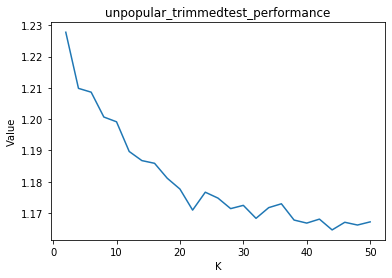

minimum RMSE for high_variance_trimmed is 1.6251


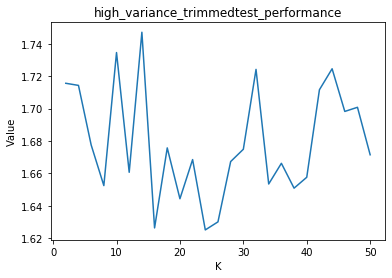

In [0]:
from surprise import  accuracy
from surprise.model_selection import KFold

trim_dict ={
    'popular_trimmed': popular_trimming,
    'unpopular_trimmed': unpopular_trimming,
    'high_variance_trimmed': high_variance_trimming
}
sim_options =  {
    'name' : 'pearson',
    'user_based': True
}

N_splits = 10
kf = KFold(n_splits=N_splits)

K_tuple = np.arange(2, 52, 2)
length = len(K_tuple)
trimmed_test_rmse = {}

for trim_name in trim_dict.keys():
    trimmed_test_rmse[trim_name] = [0] * length

for i in range(length):
    algo = NMF(n_factors=K_tuple[i],biased=False)
    for trainset, testset in kf.split(data):
        algo.fit(trainset)
        for trim_name in trim_dict.keys():
            trim_method = trim_dict[trim_name]
            trimmed_test_set = trim_method(testset, VMN)
            predictions = algo.test(trimmed_test_set)
            trimmed_test_rmse[trim_name][i] += accuracy.rmse(predictions, verbose=False)
    for trim_name in trim_dict.keys():
        trimmed_test_rmse[trim_name][i] /= 10

for trim_name in trim_dict.keys():
    print ('minimum RMSE for %s is %0.4f' %(trim_name, min(trimmed_test_rmse[trim_name])))
    plt.xlabel('K')
    plt.ylabel('Value')
    plt.title(trim_name + 'test_performance')
    plt.plot(K_tuple, trimmed_test_rmse[trim_name])
    plt.show()

#Question 22

In [0]:
nmf_best_k = K_tuple[np.argmin(aver_rmses)]

trainset, testset = train_test_split(data, test_size=0.1, random_state=42)
nmf_best = NMF(n_factors=nmf_best_k, random_state=42)
nmf_best.fit(trainset)
nmf_best_pred = nmf_best.test(testset)

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from surprise.model_selection import train_test_split


def plot_roc_curves(testset, prediction, method, threshold_values=[2.5,3,3.5,4]):
    plt.gcf().clear()
    plt.figure(figsize=(10,8))
    plt.plot([0, 1], [0, 1], 'k--')
    for threshold in threshold_values:
        y_true, y_pred = [], []
        for i in range(len(testset)):
            y_true.append(1 * (testset[i][2] >= threshold))
            y_pred.append(prediction[i].est)
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        auc_score = roc_auc_score(y_true, y_pred)
        plt.plot(fpr, tpr, label = 'Threshold: %.1f, AUC: %.4f' %(threshold,auc_score), linewidth=2)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.title('ROC Curves for {}-based Collaborative Filter'.format(method), fontweight="bold")
    plt.show()

plot_roc_curves(testset, nmf_best_pred, 'NNMF')

NameError: ignored

#Question 23

In [0]:
import re
genres = pd.read_csv('movies.csv', delimiter=',')

nmf_k20 = NMF(n_factors=20, random_state=42)
nmf_k20.fit(data.build_full_trainset())
item_factors = nmf_k20.qi

def print_latent_factors(num_latent_factors, item_factors):
    for c in range(num_latent_factors):
        movieIds = np.argsort(-item_factors[:,c])[0:10]
        print('Top 10 Values for Latent Factor %s:' %c)
        print(item_factors[movieIds, c])
        print('\nCorresponding Movie Genres:')
        for movieId in movieIds:
            print(genres.iloc[movieId]['genres'])

print_latent_factors(20, item_factors)

#Question 24

In [0]:
from surprise.prediction_algorithms.matrix_factorization import SVD
from joblib import Parallel, delayed

def mfb_compute_cross_validation_error(k):
    mfb = SVD(n_factors=k, random_state=42)
    cv = cross_validate(mfb, data, cv=KFold(n_splits=10, random_state=42))
    print('k: %s RMSE: %f MAE: %f' %(k, np.mean(cv['test_rmse']), np.mean(cv['test_mae'])))
    return np.mean(cv['test_rmse']), np.mean(cv['test_mae'])

mfb_rmse, mfb_mae = zip(*Parallel(n_jobs=-1, verbose=1, backend="multiprocessing")(map(delayed(mfb_compute_cross_validation_error), K_tuple)))


In [0]:
def plot_func(x, y, xlabel, ylabel, title):
    plt.gcf().clear()
    plt.plot(x, y, linewidth=2, color='b')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title, fontweight='bold')
    plt.show()

plot_func(K_tuple, mfb_rmse, 'k', 'RMSE', 'MF with bias-based Collaborative Filter RMSE')
plot_func(K_tuple, mfb_mae, 'k', 'MAE', 'MF with bias-based Collaborative Filter MAE')

#Question 25

In [0]:
print("Min average RMSE: %.3f; Optimal number of latent factors: %s" %(np.min(mfb_rmse), K_tuple[np.argmin(mfb_rmse)]))
print("Min average MAE: %.3f; Optimal number of latent factors: %s" %(np.min(mfb_mae), K_tuple[np.argmin(mfb_mae)]))

#Question 26

In [0]:
from surprise import accuracy
from surprise.model_selection import KFold
from surprise.prediction_algorithms.matrix_factorization import SVD
from joblib import Parallel, delayed

ratings = pd.read_csv('ratings.csv')
r_df = ratings.pivot_table('rating', 'userId', 'movieId')
frequency = r_df.shape[0] - np.sum(np.isnan(r_df), axis=0)

def popular_trimming(testset, freq):
    popular_movieId = freq[freq>2].keys()
    testset_trimmed = []
    for i in range(len(testset)):
        if testset[i][1] in popular_movieId:
            testset_trimmed.append(testset[i])
    return testset_trimmed

def mfb_pop_trim_rmse(k):
    mfb = SVD(n_factors=k, random_state=42)
    rmse = []
    for train,test in KFold(n_splits=10, random_state=42).split(data):
        mfb.fit(train)
        testset_trimmed = popular_trimming(test, frequency)
        pred = mfb.test(testset_trimmed)
        rmse.append(accuracy.rmse(pred, verbose=False))
    print('k: %s RMSE: %f' %(k, np.mean(rmse)))
    return np.mean(rmse)

mfb_rmse_pop_trim = Parallel(n_jobs=-1, verbose=1, backend="multiprocessing")(map(delayed(mfb_pop_trim_rmse),K_tuple))

In [0]:
plot_func(K_tuple, mfb_rmse_pop_trim, 'k', 'RMSE', 'RMSE after Popular Movie Trimming')

In [0]:
print("The min average RMSE after popular movie trimming is %.3f" %np.min(mfb_rmse_pop_trim))

#Question 27

In [0]:
def unpopular_trimming(test, frequency):
    unpopular_movieId = frequency[frequency<=2].keys()
    testset_trimmed = []
    for i in range(len(test)):
        if test[i][1] in unpopular_movieId:
            testset_trimmed.append(test[i])
    return testset_trimmed

def mfb_unpop_trim_rmse(k):
    mfb = SVD(n_factors=k, random_state=42)
    rmse = []
    for train,test in KFold(n_splits=10, random_state=42).split(data):
        mfb.fit(train)
        testset_trimmed = unpopular_trimming(test, frequency)
        pred = mfb.test(testset_trimmed)
        rmse.append(accuracy.rmse(pred, verbose=False))
    print('k: %s RMSE: %f' %(k, np.mean(rmse)))
    return np.mean(rmse)

mfb_rmse_unpop_trim = []
mfb_rmse_unpop_trim = Parallel(n_jobs=-1, verbose=1, backend="multiprocessing")(map(delayed(mfb_unpop_trim_rmse), K_tuple))

In [0]:
plot_func(K_tuple, mfb_rmse_unpop_trim, 'k', 'Root Mean Squared Error', 'RMSE after Unpopular Movie Trimming')

In [0]:
print("The min average RMSE after unpopular movie trimming is %.3f" %np.min(mfb_rmse_unpop_trim))

#Question 28

In [0]:
def high_variance_trimming(testset, frequency, variance):
    popular_movieId = frequency[frequency>5].keys()
    high_var_movieId = variance[variance>=2].keys()
    testset_trimmed = []
    for i in range(len(testset)):
        if testset[i][1] in popular_movieId and testset[i][1] in high_var_movieId:
            testset_trimmed.append(testset[i])
    return testset_trimmed

var = np.var(r_df, axis=0)

def mfb_high_var_trim_rmse(k):
    mfb = SVD(n_factors=k, random_state=42)
    rmse = []
    for train,test in KFold(n_splits=10, random_state=42).split(data):
        mfb.fit(train)
        testset_trimmed = high_variance_trimming(test, frequency, var)
        pred = mfb.test(testset_trimmed)
        rmse.append(accuracy.rmse(pred, verbose=False))
    print('k: %s RMSE: %f' %(k, np.mean(rmse)))
    return np.mean(rmse)

mfb_rmse_high_var_trim = Parallel(n_jobs=-1, verbose=1, backend="multiprocessing")(map(delayed(mfb_high_var_trim_rmse), K_tuple))

In [0]:
plot_func(K_tuple, mfb_rmse_high_var_trim, 'k', 'RMSE', 'RMSE after High Variance Movie Trimming')

In [0]:
print("The min average RMSE after high variance movie trimming: %.3f" %np.min(mfb_rmse_high_var_trim))

#Question 29

In [0]:
from surprise.model_selection.split import train_test_split

mfb_best_k = K_tuple[np.argmin(mfb_rmse)]
train, test = train_test_split(data, test_size=0.1, random_state=42)
mfb_best = SVD(n_factors=mfb_best_k, random_state=42)
mfb_best.fit(train)
mfb_best_pred = mfb_best.test(test)

plot_roc_curves(test, mfb_best_pred, 'MF with bias')

#Question 30

In [0]:
from surprise import AlgoBase

class MyNaiveFilter(AlgoBase):
    def __init__(self):
        AlgoBase.__init__(self)
        
    def fit(self,trainset):
        AlgoBase.fit(self, trainset)
        self.trainset = trainset
        self.means = {}
        for key in self.trainset.ur:
            userRating = self.trainset.ur[key]
            mean = np.mean([rating for (_, rating) in userRating])
            self.means[key] = mean
        return self
    
    def estimate(self,u,i):
        if self.means.__contains__(u):
          return self.means[u]
        else:
          return 0
            

In [0]:
naive_rmse = []
myNaiveFilter = MyNaiveFilter()
result = cross_validate(myNaiveFilter,data,measures=['RMSE'],cv=10, verbose=False)
naive_rmse.append(np.mean(result['test_rmse']))
print('average RMSE is: ', naive_rmse)

average RMSE is:  [0.9409418732239617]


# Question 31,32,33

In [0]:
trimmed_test_rmse = {}

for trim_name in trim_dict.keys():
    trimmed_test_rmse[trim_name] = [0]

myNaiveFilter = MyNaiveFilter()

for trainset, testset in kf.split(data):
  myNaiveFilter.fit(trainset)
  for trim_name in trim_dict.keys():
    trim_method = trim_dict[trim_name]
    trimmed_test_set = trim_method(testset, VMN)
    predictions = myNaiveFilter.test(trimmed_test_set)
    trimmed_test_rmse[trim_name] += accuracy.rmse(predictions, verbose=False)


for trim_name in trim_dict.keys():
  trimmed_test_rmse[trim_name] = trimmed_test_rmse[trim_name]/10


for trim_name in trim_dict.keys():
  result_rmse = trimmed_test_rmse[trim_name]
  print('average RMSE for {0} is {1}'.format(trim_name,result_rmse))

average RMSE for popular_trimmed is [0.93904446]
average RMSE for unpopular_trimmed is [0.97524317]
average RMSE for high_variance_trimmed is [1.45290941]


# Question 34

Computing the pearson similarity matrix...
Done computing similarity matrix.


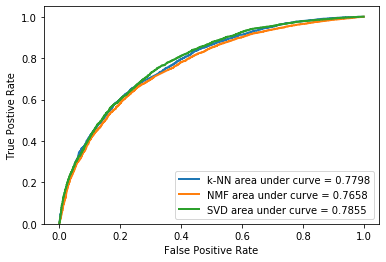

In [0]:
!pip install scikit-surprise
from surprise.model_selection.split import train_test_split
from surprise import NMF
from surprise import SVD
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import Reader
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import numpy as np
import matplotlib.pyplot as plt

def binarization(Prediction_list, threshold):
    return [1 if Prediction[2] > threshold else 0 for Prediction in Prediction_list]

Truncateddf = df.iloc[:, :3]
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(Truncateddf, reader)
trainset, testset = train_test_split(data, test_size=0.1)
threshold = 3

sim_options =  {'name' : 'pearson','user_based': True}
knn = KNNWithMeans(k=20, sim_options=sim_options)
knn.fit(trainset)
knn_result = knn.test(testset)
knn_estimation_score = [predict[3] for predict in knn_result]
knn_binarized_test = binarization(knn_result, threshold)
knn_fpr, knn_tpr, _ = roc_curve(knn_binarized_test, knn_estimation_score)
knn_roc_auc = auc(knn_fpr, knn_tpr)

nmf = NMF(n_factors=20,biased=False)
nmf.fit(trainset)
nmf_result = nmf.test(testset)
nmf_estimation_score = [predict[3] for predict in nmf_result]
nmf_binarized_test = binarization(nmf_result, threshold)
nmf_fpr, nmf_tpr, _ = roc_curve(nmf_binarized_test, nmf_estimation_score)
nmf_roc_auc = auc(nmf_fpr, nmf_tpr)

svd = SVD(n_factors=22, biased=True)
svd.fit(trainset)
svd_result = svd.test(testset)
svd_estimation_score = [predict[3] for predict in svd_result]
svd_binarized_test = binarization(svd_result, threshold)
svd_fpr, svd_tpr, _ = roc_curve(svd_binarized_test, svd_estimation_score)
svd_roc_auc = auc(svd_fpr, svd_tpr)

fig, ax = plt.subplots()
ax.plot(knn_fpr, knn_tpr, lw=2, label='k-NN area under curve = %0.4f' % knn_roc_auc)
ax.plot(nmf_fpr, nmf_tpr, lw=2, label='NMF area under curve = %0.4f' % nmf_roc_auc)
ax.plot(svd_fpr, svd_tpr, lw=2, label='SVD area under curve = %0.4f' % svd_roc_auc)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Postive Rate')
ax.legend(loc='lower right')
plt.show()

# Q36


In [0]:
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.model_selection import KFold
import matplotlib.pyplot as plt


threshold = 3
trange = [i for i in range(1, 26)]
knn_precision = []
knn_recall = []
sim_options =  {'name' : 'pearson','user_based': True}
N_splits = 10
kf = KFold(n_splits=N_splits)

for t in trange:
    temp_precision = []
    temp_recall = []
    for trainset, testset in kf.split(data):
        knn = KNNWithMeans(k=20, sim_options=sim_options)
        knn.fit(trainset)
        trimmed_testset = datatrim(testset, t)
        result = knn.test(trimmed_testset)
        precisions, recalls = precision_recall(result, t)
        mean_prec = sum(prec for prec in precisions.values()) / len(precisions)
        mean_recall = sum(rec for rec in recalls.values()) / len(recalls)
        temp_precision.append(mean_prec)
        temp_recall.append(mean_recall)

    final_mean_precision = sum(prec for prec in temp_precision) / len(temp_precision)
    final_mean_recall = sum(rec for rec in temp_recall) / len(temp_recall)
    knn_precision.append(final_mean_precision)
    knn_recall.append(final_mean_recall)



Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

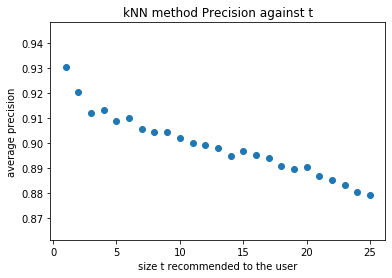

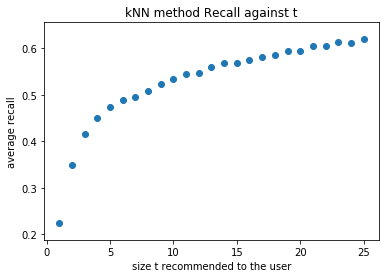

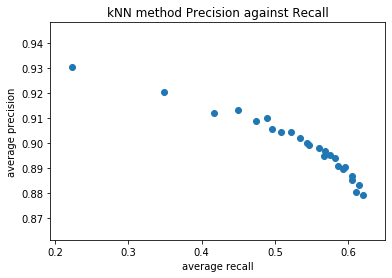

In [0]:
plt.xlabel('size t recommended to the user')
plt.ylabel('average precision')
plt.title('kNN method Precision against t')
plt.scatter(trange,knn_precision)
plt.show()

plt.xlabel('size t recommended to the user')
plt.ylabel('average recall')
plt.title('kNN method Recall against t')
plt.scatter(trange,knn_recall)
plt.show()

plt.xlabel('average recall')
plt.ylabel('average precision')
plt.title('kNN method Precision against Recall')
plt.scatter(knn_recall,knn_precision)
plt.show()

# Q37

In [0]:
from surprise import NMF

threshold = 3
trange = [i for i in range(1, 26)]
nmf_precision = []
nmf_recall = []
N_splits = 10
kf = KFold(n_splits=N_splits)

for t in trange:
    temp_precision = []
    temp_recall = []
    for trainset, testset in kf.split(data):
        nmf = NMF(n_factors=20, biased=False)
        nmf.fit(trainset)
        trimmed_testset = datatrim(testset, t)
        result = nmf.test(trimmed_testset)
        precisions, recalls = precision_recall(result, t)
        mean_prec = sum(prec for prec in precisions.values()) / len(precisions)
        mean_recall = sum(rec for rec in recalls.values()) / len(recalls)
        temp_precision.append(mean_prec)
        temp_recall.append(mean_recall)
    final_mean_precision = sum(prec for prec in temp_precision) / len(temp_precision)
    final_mean_recall = sum(rec for rec in temp_recall) / len(temp_recall)
    nmf_precision.append(final_mean_precision)
    nmf_recall.append(final_mean_recall)

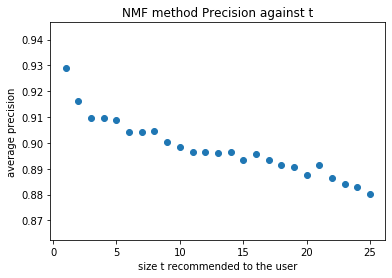

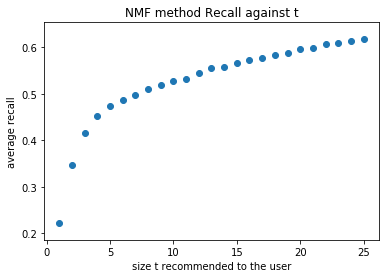

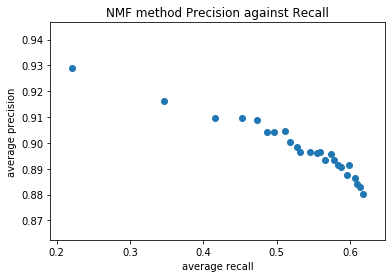

In [0]:
plt.xlabel('size t recommended to the user')
plt.ylabel('average precision')
plt.title('NMF method Precision against t')
plt.scatter(trange,nmf_precision)
plt.show()

plt.xlabel('size t recommended to the user')
plt.ylabel('average recall')
plt.title('NMF method Recall against t')
plt.scatter(trange,nmf_recall)
plt.show()

plt.xlabel('average recall')
plt.ylabel('average precision')
plt.title('NMF method Precision against Recall')
plt.scatter(nmf_recall,nmf_precision)
plt.show()

# Q38

In [0]:
from surprise import SVD

threshold = 3
trange = [i for i in range(1, 26)]
svd_precision = []
svd_recall = []
N_splits = 10
kf = KFold(n_splits=N_splits)

for t in trange:
    temp_precision = []
    temp_recall = []
    for trainset, testset in kf.split(data):
        svd = SVD(n_factors=22,biased=True)
        svd.fit(trainset)
        trimmed_testset = datatrim(testset, t)
        result = svd.test(trimmed_testset)
        precisions, recalls = precision_recall(result, t)
        mean_prec = sum(prec for prec in precisions.values()) / len(precisions)
        mean_recall = sum(rec for rec in recalls.values()) / len(recalls)
        temp_precision.append(mean_prec)
        temp_recall.append(mean_recall)
    final_mean_precision = sum(prec for prec in temp_precision) / len(temp_precision)
    final_mean_recall = sum(rec for rec in temp_recall) / len(temp_recall)
    svd_precision.append(final_mean_precision)
    svd_recall.append(final_mean_recall)

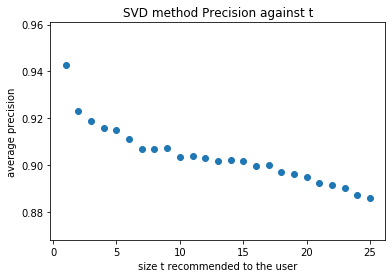

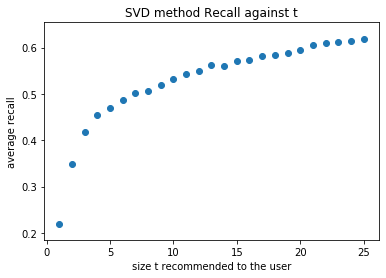

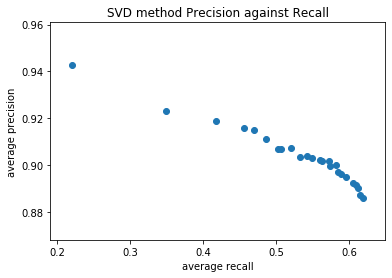

In [0]:
plt.xlabel('size t recommended to the user')
plt.ylabel('average precision')
plt.title('SVD method Precision against t')
plt.scatter(trange,svd_precision)
plt.show()

plt.xlabel('size t recommended to the user')
plt.ylabel('average recall')
plt.title('SVD method Recall against t')
plt.scatter(trange,svd_recall)
plt.show()

plt.xlabel('average recall')
plt.ylabel('average precision')
plt.title('SVD method Precision against Recall')
plt.scatter(svd_recall,svd_precision)
plt.show()

# Q39

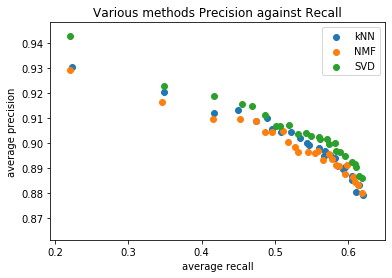

In [0]:
plt.xlabel('average recall')
plt.ylabel('average precision')
plt.title('Various methods Precision against Recall')
plt.scatter(knn_recall,knn_precision,label = 'kNN')
plt.scatter(nmf_recall,nmf_precision,label = 'NMF')
plt.scatter(svd_recall,svd_precision,label = 'SVD')
plt.legend(loc = 'best')
plt.show()